# Project for Data Mining - Penguin Species Clustering

## Agampreet Bajaj

## What are we solving?
We are trying to identify natural groupings of penguins based on their physical characteristics; including culmen length, culmen depth, flipper length, body mass, and sex. This project helps us understand how these traits vary among penguins and whether they form distinct size or feature-based clusters. By using K-Means clustering, we can explore how penguins differ in body proportions and identify patterns that may relate to biological or environmental factors.

## What is the data?
The dataset contains hundreds of penguin records, each representing a unique bird. The numeric features (lengths and mass) are continuous variables measured in millimeters and grams, while the categorical feature (sex) indicates whether the penguin is male or female. This data is commonly used in biology and data science to explore species diversity, body size variation, and the relationship between morphology and environment.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv("penguins.csv")
df

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE
...,...,...,...,...,...
339,NaN,NaN,NaN,NaN,NaN
340,46.8,14.3,215.0,4850.0,FEMALE
341,50.4,15.7,222.0,5750.0,MALE
342,45.2,14.8,212.0,5200.0,FEMALE


In [3]:
num_cols = ["culmen_length_mm","culmen_depth_mm","flipper_length_mm","body_mass_g"]
print(df[num_cols].describe().round(2))

       culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g
count            342.00           342.00             342.00       342.00
mean              43.92            17.15             214.01      4201.75
std                5.46             1.97             260.56       801.95
min               32.10            13.10            -132.00      2700.00
25%               39.22            15.60             190.00      3550.00
50%               44.45            17.30             197.00      4050.00
75%               48.50            18.70             213.75      4750.00
max               59.60            21.50            5000.00      6300.00


The table above summarizes key statistics for each numeric feature in the dataset. The mean and standard deviation show the average and variability of each measurement. For example, the average culmen (beak) length is about 44 mm, while the average body mass is around 4200 g. The minimum and maximum values highlight the range of data, and the 25%, 50%, and 75% rows show quartiles, which divide the data into four equal parts. Notably, the flipper length column has unusual negative and extremely high values, suggesting there may be outliers or data entry errors that should be cleaned before clustering.

# Visualization

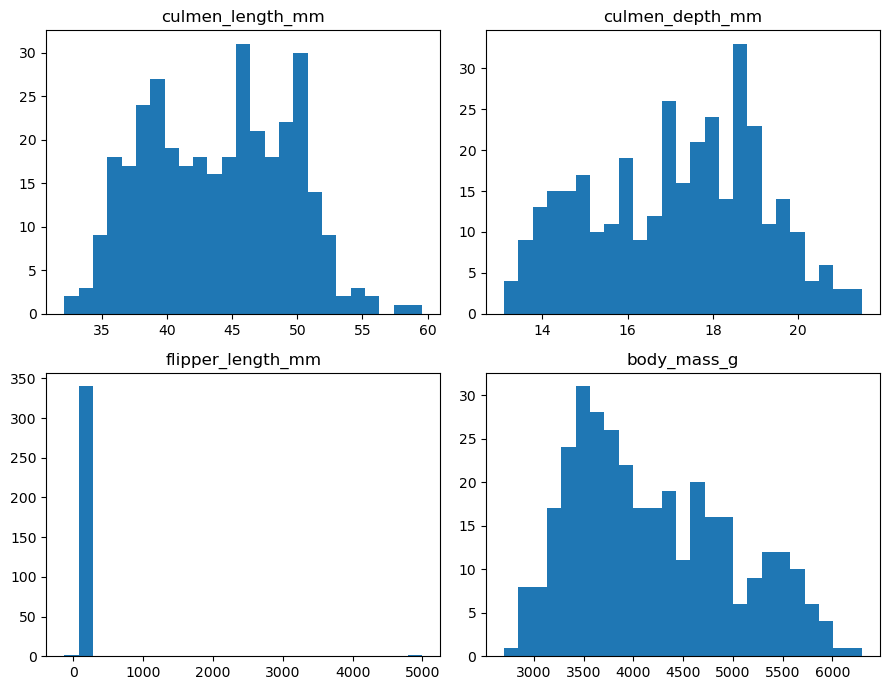

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(9,7))
for ax, col in zip(axes.ravel(), num_cols):
    ax.hist(df[col].dropna(), bins=25)
    ax.set_title(col)
plt.tight_layout(); plt.show()

The histograms above show how each numerical feature in the penguin dataset is distributed. Most penguins have a culmen length between 40 and 50 mm, while the culmen depth mainly falls between 15 and 19 mm. The flipper length data is concentrated within a small range but also shows a few extreme outliers that may need to be cleaned before clustering. The body mass varies widely, mostly between 3000 and 6000 grams, suggesting natural differences across penguin types or sexes. Overall, these graphs help us understand the spread and variability of each feature, which is an important step before applying K-Means clustering, as the algorithm is sensitive to differences in scale and outliers.

# Preprocessing

In [5]:
X = df[num_cols].dropna().copy()

# 5b) Remove extreme outliers with an IQR fence (per-feature)
def iqr_filter(frame, cols, k=1.5):
    mask = pd.Series(True, index=frame.index)
    for c in cols:
        q1, q3 = frame[c].quantile([0.25, 0.75])
        iqr = q3 - q1
        low, high = q1 - k*iqr, q3 + k*iqr
        mask &= frame[c].between(low, high)
    return frame[mask]

X_clean = iqr_filter(X, num_cols, k=1.5)

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

Before performing clustering, the data must be cleaned and standardized to ensure accurate results. In this step, we remove any missing values in the numeric columns and then apply standard scaling, which converts all features to a similar scale by centering them around zero with a standard deviation of one. This prevents larger numerical values, such as body mass (measured in grams), from dominating smaller measurements like culmen depth (measured in millimeters). Standardizing the data ensures that each feature contributes equally to the distance calculations used by the K-Means algorithm.

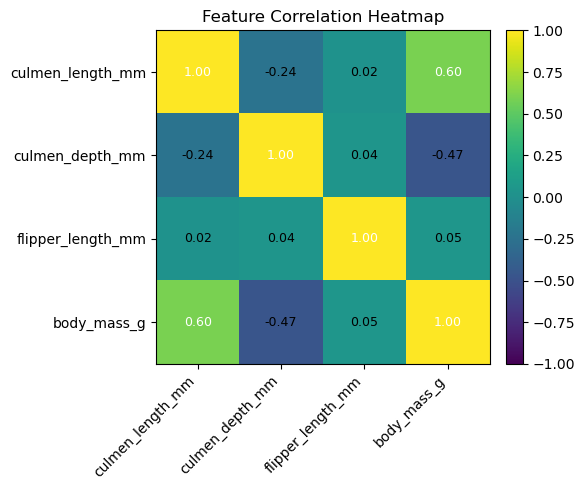

In [7]:
corr = df[num_cols].corr().values
labels = num_cols

plt.figure(figsize=(6,5))
im = plt.imshow(corr, vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.yticks(range(len(labels)), labels)
plt.title("Feature Correlation Heatmap")

for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, f"{corr[i,j]:.2f}", ha="center", va="center", fontsize=9, color="white" if abs(corr[i,j])>0.5 else "black")

plt.tight_layout()
plt.show()

The correlation heatmap shows how the penguin features relate to each other. A positive value means that as one measurement increases, the other tends to increase too, while a negative value means they move in opposite directions. In this dataset, culmen length and body mass show a moderately strong positive correlation (0.60), suggesting larger penguins tend to have longer beaks. Meanwhile, culmen depth has a negative relationship with both body mass and culmen length, indicating that deeper beaks don’t necessarily correspond to heavier or longer penguins. These relationships help us understand which features vary together before applying clustering.

# Modeling

In [8]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)

df_clusters = X_clean.copy()
df_clusters["cluster"] = kmeans.labels_

centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=num_cols
)

cluster_names = []
for i in range(k):
    name = f"Cluster {i}"
    cluster_names.append(name)
centers.index = cluster_names

print(centers.round(2))

           culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g
Cluster 0             38.24            18.09             188.33      3578.44
Cluster 1             47.50            14.98             217.19      5076.02
Cluster 2             47.59            18.75             196.98      3897.97


C:\Users\bajaj_2zp1lvw\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


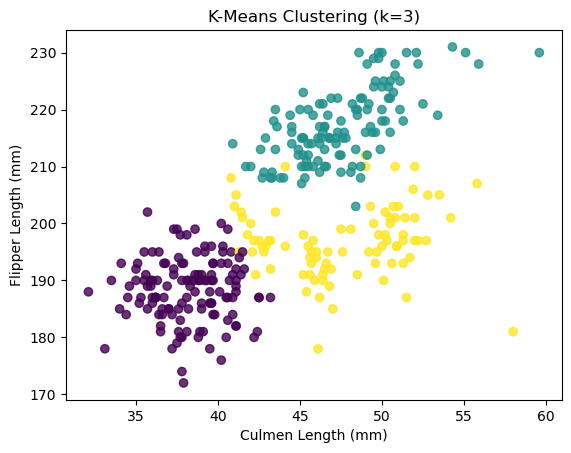

In [9]:
plt.scatter(df_clusters["culmen_length_mm"], df_clusters["flipper_length_mm"],
            c=df_clusters["cluster"], cmap="viridis", alpha=0.8)
plt.xlabel("Culmen Length (mm)")
plt.ylabel("Flipper Length (mm)")
plt.title(f"K-Means Clustering (k={k})")
plt.show()

We apply the K-Means algorithm to group penguins into k clusters based on their standardized measurements. After fitting the model, each penguin receives a cluster label indicating the group it is most similar to. We then convert the cluster centers back into the original units (millimeters and grams) so they are easy to interpret. These centers summarize each group’s typical beak size, flipper length, and body mass. The simple scatter plot provides a quick visual check that the clusters form reasonable “clouds” in feature space. If needed, we can adjust k (e.g., 2, 3, or 4) and re-run to see how the grouping changes.